In [32]:
import pandas as pd
import numpy as np
import zipfile
import json
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [33]:
#read structure of json file
json_filename = "C:/Users/allen/allen/MADS/SIADS _697/data/0000.json"
df = pd.read_json(json_filename, orient='index')
df = df.reset_index()
print(df)

                         index  \
0                           id   
1                    num_sales   
2             background_color   
3                    image_url   
4            image_preview_url   
5          image_thumbnail_url   
6           image_original_url   
7                animation_url   
8       animation_original_url   
9                         name   
10                 description   
11               external_link   
12              asset_contract   
13                   permalink   
14                  collection   
15                    decimals   
16              token_metadata   
17                       owner   
18                 sell_orders   
19                     creator   
20                      traits   
21                   last_sale   
22                     top_bid   
23                listing_date   
24                  is_presale   
25  transfer_fee_payment_token   
26                transfer_fee   
27                    token_id   

             

In [34]:
#peak at last sale structure
field = df[df['index'] == 'last_sale'][0]
print(field)
field_dic = field.to_list()[0]
print(field_dic.keys())
print(field_dic['total_price'])
print(field_dic['quantity'])
print(field_dic["event_timestamp"])
#print(field_dic['transaction'])

21    {'asset': {'decimals': None, 'token_id': '0'},...
Name: 0, dtype: object
dict_keys(['asset', 'asset_bundle', 'event_type', 'event_timestamp', 'auction_type', 'total_price', 'payment_token', 'transaction', 'created_date', 'quantity'])
0
1
2018-11-30T07:32:35


In [35]:
#list of metadata collections to analyze
zip_files_list = list()
zip_files_list.append(("Crypto Punks","C:/Users/allen/allen/MADS/SIADS _697/data/cryptopunks.zip"))
zip_files_list.append(("Bored Ape Yacht Club","C:/Users/allen/allen/MADS/SIADS _697/data/boredapeyachtclub_metadata_archive.zip"))
zip_files_list.append(("Bored Ape Yacht Club - Highest Price Filter","C:/Users/allen/allen/MADS/SIADS _697/data/boredapeyachtclub_valuable_metadata_archive.zip"))

zip_files_list.append(("Hape Prime","C:/Users/allen/allen/MADS/SIADS _697/data/hapeprime_metadata_archive.zip"))
zip_files_list.append(("Meebits","C:/Users/allen/allen/MADS/SIADS _697/data/meebits_metadata_archive.zip"))





In [36]:
# open zipped dataset and create traits and sales dataframes by id


#hold list of df for each collection
collection_dfs_list = list()
#hold list of trait_df for each collection
traits_dfs_list = list()
#hold list of sales_df for each collection
sales_dfs_list = list()

#iterate over each zip files' collection
for zipfilename in zip_files_list:
    
    #collection ids for each collection
    collection_list = list()
    collection_df = None
    #hold traits details for each collection
    traits_df = None
    full_traits_list = list()
    #hold sales details for each collection    
    sales_df = None
    full_sales_list = list()    
    
    with zipfile.ZipFile(zipfilename[1]) as z:

        listOfiles = z.namelist()
        for fileName in listOfiles:
            #just the json
            if ".json" in fileName:

                with z.open(fileName) as f:
                    #print(fileName)

                    #read nft metadata into a df
                    df = pd.read_json(f, orient='index')
                    df = df.reset_index()            

                    #creates traits dict list
                    traits_series = df[df['index'] == 'traits'][0]
                    traits_list = traits_series.to_list()[0]
                    #add id field to each trait_dict in list
                    id_val = df[df['index'] == 'token_id'][0].to_list()[0]
                    for traits_dict in traits_list:
                        traits_dict['token_id'] = id_val
                    full_traits_list.extend(traits_list)

                    #add nft to collections
                    nft_dic = dict()
                    nft_dic['id'] = id_val
                    collection_list.append(nft_dic)


                    #create costs list
                    field_dic = df[df['index'] == 'last_sale'][0].to_list()[0]

                    if field_dic is not None:

                        sales_dic = dict()
                        sales_dic['id'] = id_val
                        sales_dic['token_id'] = field_dic['asset']['token_id']
                        sales_dic['total_price'] = int(field_dic['total_price'])
                        if field_dic['quantity'] is None:
                                sales_dic['quantity'] = 1
                        else:
                            sales_dic['quantity'] = int(field_dic['quantity'])
                        sales_dic['event_timestamp'] = field_dic['event_timestamp']
                        sales_dic['decimals'] = int(field_dic['payment_token']['decimals'])
                        sales_dic['eth_price'] = float(field_dic['payment_token']['eth_price'])
                        sales_dic['usd_price'] = float(field_dic['payment_token']['usd_price'])

                        # Converting sales price from WEI to ETH the usd
                        #priceUSD = total_price / 10^18 * payment_token.usd_price / quantity)
                        sales_dic['total_price_usd'] = sales_dic['total_price']/(10**sales_dic['decimals'])  * sales_dic['usd_price']/sales_dic['quantity']
                        if sales_dic['total_price_usd'] > 0:
                            sales_dic['total_price_usd_log'] = np.log10(sales_dic['total_price_usd'])
                        else:
                            sales_dic['total_price_usd_log'] = 0
                        full_sales_list.append(sales_dic)

    traits_df = pd.DataFrame(full_traits_list)
    traits_df = traits_df.astype({"token_id": int, "trait_count": int})
    traits_df['collection_name'] = zipfilename[0]
    #print(traits_df.head(2))  
    traits_dfs_list.append(traits_df)
    
    sales_df = pd.DataFrame(full_sales_list)
    sales_df = sales_df.astype({"token_id": int, "total_price": float, "eth_price": float, "usd_price": float, "total_price_usd":float})
    sales_df['collection_name'] = zipfilename[0]

    #print(sales_df.head(2))
    sales_dfs_list.append(sales_df)

    collection_df = pd.DataFrame(collection_list)
    collection_df['collection_name'] = zipfilename[0]

    #print(collection_df.head(2))
    collection_dfs_list.append(collection_df)



In [37]:
sales_dfs_list[3].sort_values(by=['total_price_usd'], ascending=False)

,id,token_id,total_price,quantity,event_timestamp,decimals,eth_price,usd_price,total_price_usd,total_price_usd_log,collection_name
3724,217,217,9.900000e+19,1,2022-02-05T17:30:27,18,1.0,2798.68,277069.320000,5.442588,Hape Prime
2664,650,650,9.000000e+19,1,2022-02-06T18:43:41,18,1.0,2805.23,252470.700000,5.402211,Hape Prime
832,546,546,9.000000e+19,1,2022-02-10T06:45:45,18,1.0,2805.23,252470.700000,5.402211,Hape Prime
170,6688,6688,7.600000e+19,1,2022-02-28T04:57:38,18,1.0,2782.85,211496.600000,5.325303,Hape Prime
1877,1389,1389,6.000000e+19,1,2022-02-09T04:40:06,18,1.0,2805.23,168313.800000,5.226120,Hape Prime
...,...,...,...,...,...,...,...,...,...,...,...
614,3490,3490,1.100000e+18,1,2022-03-08T22:12:05,18,1.0,2805.23,3085.753000,3.489361,Hape Prime
837,4913,4913,1.100000e+18,1,2022-03-08T22:09:51,18,1.0,2778.51,3056.361000,3.485205,Hape Prime
1779,371,371,6.988000e+16,1,2022-01-24T16:24:31,18,1.0,2798.68,195.571758,2.291306,Hape Prime
3623,1304,1304,1.000000e+15,1,2022-03-02T23:35:00,18,1.0,2805.23,2.805230,0.447968,Hape Prime


In [38]:
traits_dfs_list[1].head(5)  

,trait_type,value,display_type,max_value,trait_count,order,token_id,collection_name
0,Mouth,Grin Gold Grill,None,None,91,None,3721,Bored Ape Yacht Club
1,Hat,Fez,None,None,377,None,3721,Bored Ape Yacht Club
2,Background,Aquamarine,None,None,1266,None,3721,Bored Ape Yacht Club
3,Fur,Pink,None,None,511,None,3721,Bored Ape Yacht Club
4,Eyes,Angry,None,None,432,None,3721,Bored Ape Yacht Club


In [39]:
for traits_df in traits_dfs_list:
    top_traits_df = traits_df.sort_values(by=['value'], ascending=True)
    print(top_traits_df.head(5)[['token_id','trait_type','value']])


       token_id trait_type         value
20609       281  accessory  0 attributes
37324      6487  accessory  0 attributes
3363        510  accessory  0 attributes
39520       641  accessory  0 attributes
20317      2204  accessory  0 attributes
       token_id trait_type value
22560      9242       Eyes    3d
25611      2286       Eyes    3d
1769        475       Eyes    3d
17598      4611       Eyes    3d
12093      3960       Eyes    3d
      token_id trait_type value
1804      1377       Eyes    3d
4419      1485       Eyes    3d
2278      5743       Eyes    3d
3569      5001       Eyes    3d
907       4969       Eyes    3d
       token_id    trait_type         value
6490        117  Heart Number  000215535133
62577       379  Heart Number  000218157178
13894      1711  Heart Number  000231477073
35153      5345  Heart Number  000267818191
69539      5681  Heart Number  000271178002
        token_id     trait_type value
192275      5434  Jersey Number     0
97277        444  Jersey

   trait_type         value  total count
8   accessory  7 attributes            1
0   accessory  0 attributes            8
95       type         Alien            9
7   accessory  6 attributes           11
96       type           Ape           24


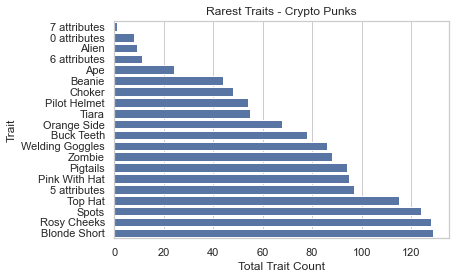

    trait_type                      value  total count
152      Mouth       Bored Unshaven Pizza           26
148      Mouth      Bored Unshaven Dagger           28
14     Clothes                 Black Suit           42
150      Mouth  Bored Unshaven Party horn           45
94         Fur                 Solid Gold           45


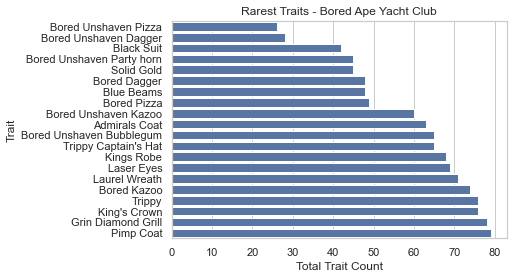

    trait_type                  value  total count
143      Mouth            Bored Pizza            3
148      Mouth  Bored Unshaven Dagger            6
152      Mouth   Bored Unshaven Pizza            6
8      Clothes          Admirals Coat            7
61        Eyes             Blue Beams            8


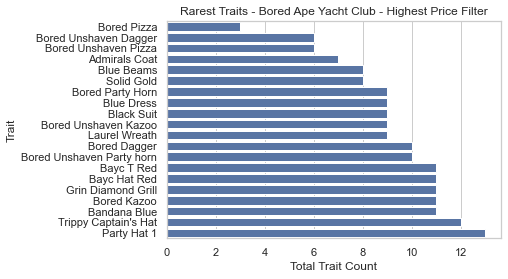

        trait_type         value  total count
4682  Heart Number  442062724747            1
5872  Heart Number  586745365492            1
5871  Heart Number  586672842026            1
5870  Heart Number  586671243515            1
5869  Heart Number  586451825574            1


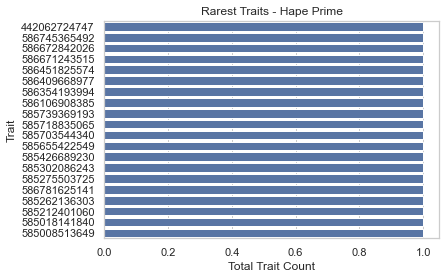

       trait_type                      value  total count
421  Tattoo Motif      CBFBSSBFBC,CBFBSSBFBC            1
543  Tattoo Motif                DFDBL,DFDBL            1
544  Tattoo Motif              DFDDFD,DFDDFD            1
545  Tattoo Motif  DFFBLDLFBCBD,DFFBLDLFBCBD            1
546  Tattoo Motif                DFFCL,DFFCL            1


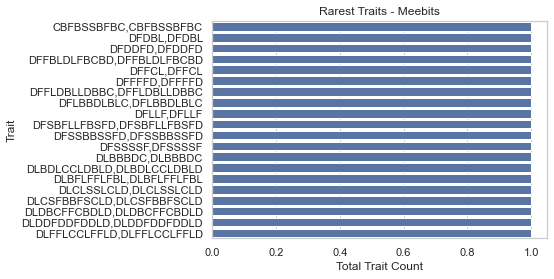

In [40]:
#rare traits
#traits_group_df = traits_df[traits_df['trait_type'] == "accessory"].groupby(['trait_type','value']).size().reset_index()

for idx, traits_df in enumerate(traits_dfs_list):
    traits_group_df = traits_df.groupby(['trait_type','value']).size().reset_index()
    traits_group_df.rename({'0': 'count'}, axis=1, inplace=True)
    traits_group_df.columns = ['trait_type', 'value', 'total count']
    traits_group_df = traits_group_df.sort_values(by=['total count'], ascending=True)
    print(traits_group_df.head(5))
    rare_df = traits_group_df.head(20)
    ax = sns.barplot(x="total count", y="value", data=rare_df, label="Count", color="b")
    ax.set(xlabel='Total Trait Count', ylabel='Trait', title='Rarest Traits - '+ zip_files_list[idx][0])
    plt.savefig('Plot_Rarest_Traits_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()
    

   trait_type         value  total count
98       type          Male         6039
97       type        Female         3840
32  accessory       Earring         2459
3   accessory  3 attributes         2342
2   accessory  2 attributes         1909


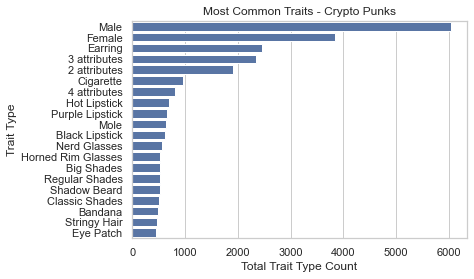

    trait_type           value  total count
135      Mouth           Bored         2252
62        Eyes           Bored         1698
144      Mouth  Bored Unshaven         1538
82         Fur           Brown         1357
85         Fur      Dark Brown         1339


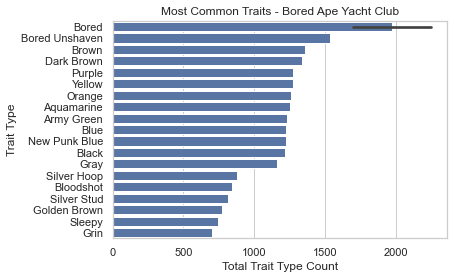

     trait_type           value  total count
135       Mouth           Bored          296
62         Eyes           Bored          233
144       Mouth  Bored Unshaven          209
82          Fur           Brown          199
0    Background      Aquamarine          186


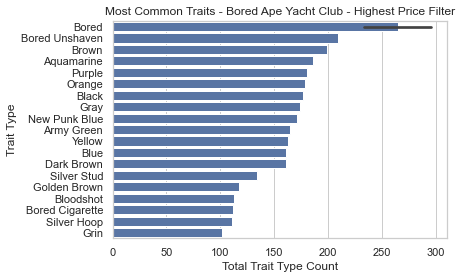

    trait_type   value  total count
905       Head    HAPE         4561
887    Haircut  Braids         1926
875        Fur   White          924
694       Eyes   Brown          878
693       Eyes    Blue          850


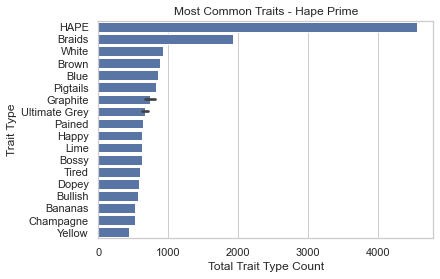

       trait_type      value  total count
1058         Type      Human        18693
31     Hair Color       Dark        11591
189         Shoes     Canvas         3777
124   Pants Color      Denim         3748
122   Pants Color  Dark Gray         3672


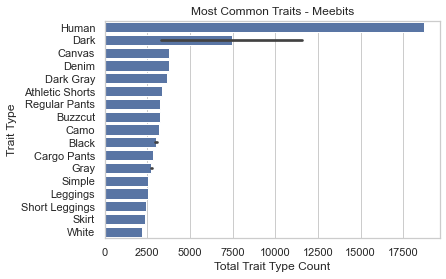

In [41]:
#most common traits

for idx, traits_df in enumerate(traits_dfs_list):
    traits_group_df = traits_df.groupby(['trait_type','value']).size().reset_index()
    traits_group_df.rename({'0': 'count'}, axis=1, inplace=True)
    traits_group_df.columns = ['trait_type', 'value', 'total count']
    traits_group_df = traits_group_df.sort_values(by=['total count'], ascending=False)
    print(traits_group_df.head(5))
    rare_df = traits_group_df.head(20)
    ax = sns.barplot(x="total count", y="value", data=rare_df, label="Count", color="b")
    ax.set(xlabel='Total Trait Type Count', ylabel='Trait Type', title='Most Common Traits - '+ zip_files_list[idx][0])
    plt.savefig('Plot_Most_Common_Traits_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()

In [42]:
#calculate rarity score and provide list of highest, and put into traits_score_dfs_list
traits_score_dfs_list = list()

for traits_df in traits_dfs_list:
    traits_score_df = traits_df.groupby(['trait_type','value']).size().reset_index()
    traits_score_df['trait_type_value'] = traits_score_df['trait_type'] + " : " + traits_score_df['value'] 
    traits_score_df.columns = ['trait_type', 'value', 'total count', 'trait_type_value',]
    traits_score_df = traits_score_df.sort_values(by=['total count'], ascending=False)
    traits_score_df = traits_score_df.astype({"total count": int})
    traits_score_df['rarity_score'] = 1/(traits_score_df['total count']/len(collection_dfs_list))
    traits_score_df['rarity_score_log'] = np.log10(traits_score_df['rarity_score'])
    traits_score_df = traits_score_df[['trait_type_value', 'rarity_score', 'rarity_score_log']]
    traits_score_df = traits_score_df.sort_values(by=['rarity_score'], ascending=False)
    traits_score_dfs_list.append(traits_score_df)
    print(traits_score_df.head(5))
    #sns.barplot(x="trait_type_value", y="rarity_score_log", data=traits_score_df,
    #        label="Rarity Scores", color="b")
    #plt.show()
    
    

            trait_type_value  rarity_score  rarity_score_log
8   accessory : 7 attributes      5.000000          0.698970
0   accessory : 0 attributes      0.625000         -0.204120
95              type : Alien      0.555556         -0.255273
7   accessory : 6 attributes      0.454545         -0.342423
96                type : Ape      0.208333         -0.681241
                      trait_type_value  rarity_score  rarity_score_log
152       Mouth : Bored Unshaven Pizza      0.192308         -0.716003
148      Mouth : Bored Unshaven Dagger      0.178571         -0.748188
14                Clothes : Black Suit      0.119048         -0.924279
150  Mouth : Bored Unshaven Party horn      0.111111         -0.954243
94                    Fur : Solid Gold      0.111111         -0.954243
                  trait_type_value  rarity_score  rarity_score_log
143            Mouth : Bored Pizza      1.666667          0.221849
148  Mouth : Bored Unshaven Dagger      0.833333         -0.079181
152   M

In [43]:
#create bins
#sns.barplot(x="trait_type_value", y="rarity_score_log", data=traits_score_df,
#            label="Rarity Scores", color="b")

In [44]:
#calculate trait score based on rarity.tools calculation
token_traits_rarity_total_dfs_list = list()

for idx, traits_df in enumerate(traits_dfs_list):
    traits_group_df = traits_df.groupby(['token_id','trait_type','value']).size().reset_index()

    traits_group_df.rename({'0': 'count'}, axis=1, inplace=True)
    traits_group_df.columns = ['token_id','trait_type', 'trait_value', 'total_count']
    #combine trait type and value as the key
    traits_group_df['trait_type_value'] = traits_group_df['trait_type'] + " : " + traits_group_df['trait_value']

    #merge with traits_score_df
    token_traits_rarity_total_df = pd.merge(traits_group_df, traits_score_dfs_list[idx], on='trait_type_value')
    #group tokens on rarity_score total
    token_traits_rarity_total_df = token_traits_rarity_total_df.groupby(['token_id']).agg({'rarity_score': ['sum'], })
    token_traits_rarity_total_df.columns = ['rarity_total']
    token_traits_rarity_total_df = token_traits_rarity_total_df.reset_index()
    token_traits_rarity_total_dfs_list.append(token_traits_rarity_total_df)
    print(token_traits_rarity_total_df.head(5))
    
    

   token_id  rarity_total
0         0      0.057934
1         1      0.035793
2         2      0.037488
3         3      0.038663
4         4      0.046515
   token_id  rarity_total
0        99      0.079460
1       100      0.071614
2       101      0.061626
3       102      0.061523
4       103      0.076007
   token_id  rarity_total
0      1001      0.285406
1      1003      0.659078
2      1005      0.295857
3      1007      0.362189
4      1011      0.408392
   token_id  rarity_total
0         1      5.543373
1         2      5.872701
2         3      5.717583
3         4      5.471903
4         5      5.644319
   token_id  rarity_total
0         1      0.066163
1         2      0.144883
2         3      0.036858
3         4      0.074756
4         5      0.048310


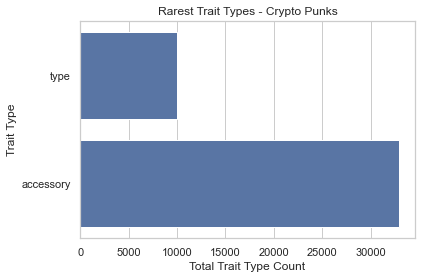

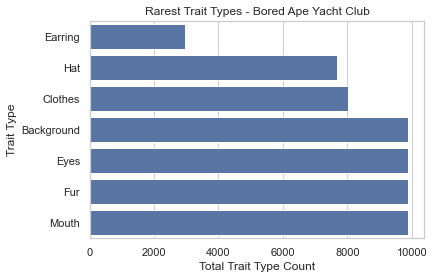

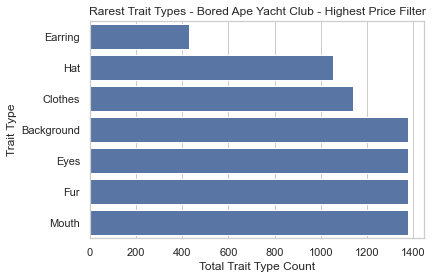

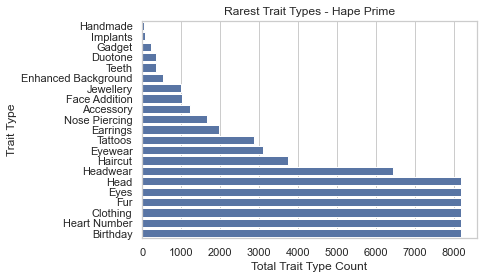

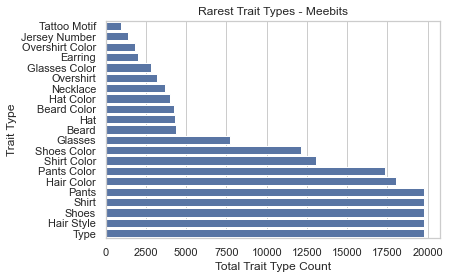

In [45]:
#display rarest trait types
for idx, traits_df in enumerate(traits_dfs_list):
    traits_type_group_df = traits_df.groupby(['trait_type']).size().reset_index()
    traits_type_group_df.rename({'0': 'count'}, axis=1, inplace=True)
    traits_type_group_df.columns = ['trait_type', 'total count']
    traits_type_group_df = traits_type_group_df.sort_values(by=['total count'], ascending=True)
    ax = sns.barplot(x="total count", y="trait_type", data=traits_type_group_df,
                label="Count", color="b")
    ax.set(xlabel='Total Trait Type Count', ylabel='Trait Type', title='Rarest Trait Types - '+ zip_files_list[idx][0])
    plt.savefig('Plot_Rarest_Trait_Types_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()

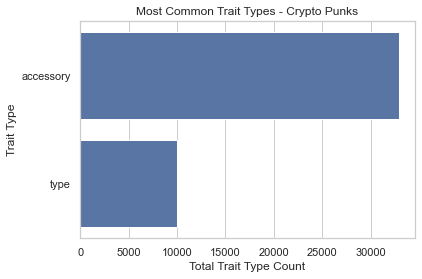

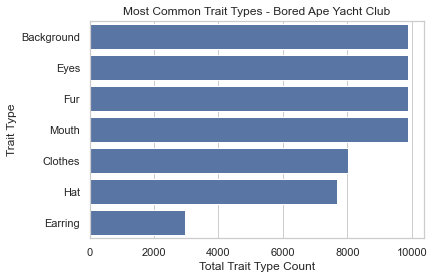

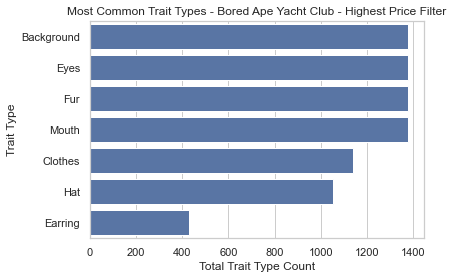

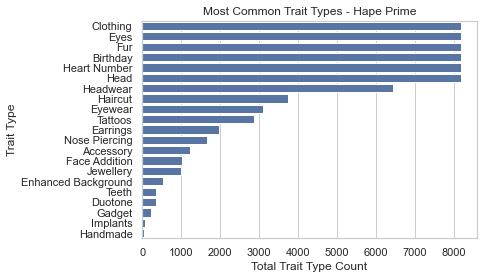

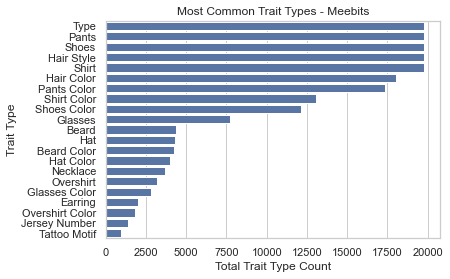

In [46]:
#display most common trait types
for idx, traits_df in enumerate(traits_dfs_list):
    traits_type_group_df = traits_df.groupby(['trait_type']).size().reset_index()
    traits_type_group_df.rename({'0': 'count'}, axis=1, inplace=True)
    traits_type_group_df.columns = ['trait_type', 'total count']
    traits_type_group_df = traits_type_group_df.sort_values(by=['total count'], ascending=False)
    ax = sns.barplot(x="total count", y="trait_type", data=traits_type_group_df,
                label="Count", color="b")
    ax.set(xlabel='Total Trait Type Count', ylabel='Trait Type', title='Most Common Trait Types - '+ zip_files_list[idx][0])
    plt.savefig('Plot_Most_Common_Trait_Types_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()

In [47]:
#display top trait values by total_price by collection
traits_sales_dfs_list = list()
for idx, traits_df in enumerate(traits_dfs_list):
    #count of traits by token_id
    token_traits_df = traits_df.groupby(['token_id']).size().reset_index()
    token_traits_df.columns = ['token_id', 'trait_count']
    traits_sales_df = pd.merge(token_traits_df, sales_dfs_list[idx], on='token_id')
    #merge in rarity_total
    traits_sales_df = pd.merge(traits_sales_df, token_traits_rarity_total_dfs_list[idx], on='token_id')
    traits_sales_df = traits_sales_df.sort_values(by=['total_price_usd_log'], ascending=False)
    print(traits_sales_df.head(5))
    traits_sales_dfs_list.append(traits_sales_df)
    
    

      token_id  trait_count    id   total_price  quantity  \
6600      9998            5  9998  1.244571e+23         1   
3630      5822            3  5822  8.000000e+21         1   
5021      7804            5  7804  4.200000e+21         1   
1705      3100            3  3100  4.200000e+21         1   
3456      5577            3  5577  2.501000e+21         1   

          event_timestamp  decimals  eth_price  usd_price  total_price_usd  \
6600  2021-10-28T23:50:37        18        1.0    2607.28     3.244944e+08   
3630  2022-02-12T20:30:36        18        1.0    2607.28     2.085824e+07   
5021  2021-03-11T00:48:39        18        1.0    2607.28     1.095058e+07   
1705  2021-03-11T20:57:01        18        1.0    2607.28     1.095058e+07   
3456  2022-02-09T03:31:23        18        1.0    2607.28     6.520807e+06   

      total_price_usd_log collection_name  rarity_total  
6600             8.511207    Crypto Punks      0.061394  
3630             7.319278    Crypto Punks      0

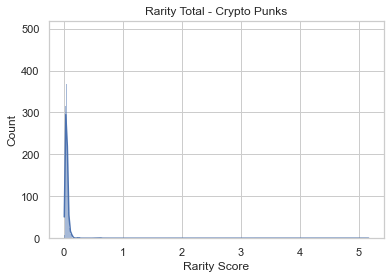

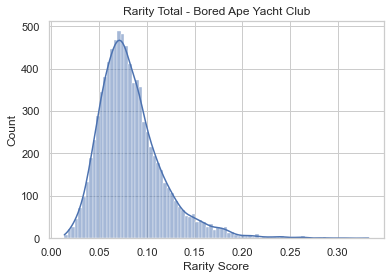

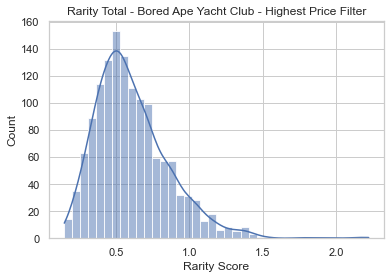

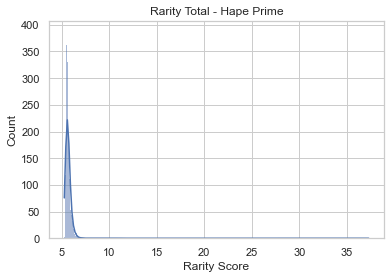

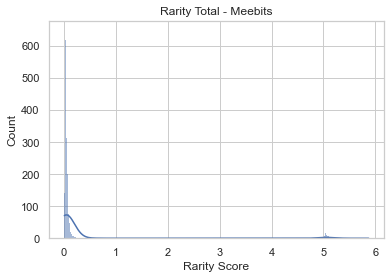

In [48]:
for idx, traits_sales_df in enumerate(traits_sales_dfs_list):
    traits_sales_df = traits_sales_df.sort_values(by=['rarity_total'], ascending=False)
    #traits_sales_df['rarity_total'].head(10).plot(kind="bar", title="Rarity Total").set(title=zip_files_list[idx][0])
    
    # Plot histogram
    ax = sns.histplot(data = traits_sales_df['rarity_total'], kde = True)
    ax.set(xlabel='Rarity Score', ylabel='Count', title='Rarity Total - '+ zip_files_list[idx][0])
    plt.savefig('Plot_Rarity_Total_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()
    

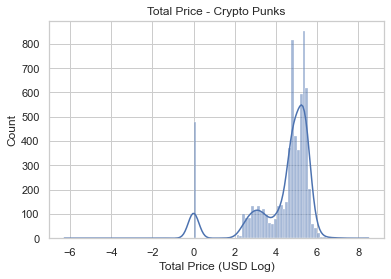

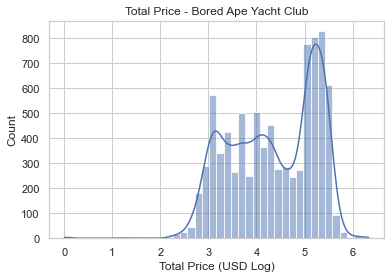

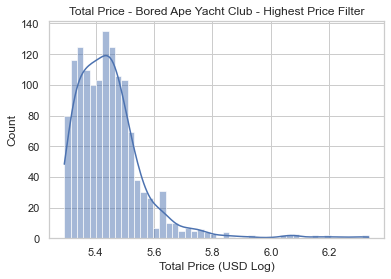

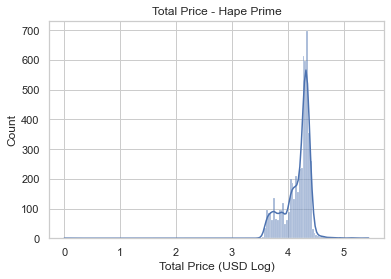

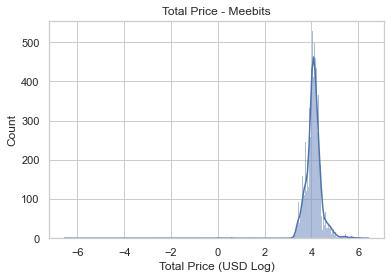

In [49]:
for idx, sales_df in enumerate(sales_dfs_list):
    sales_df = sales_df.sort_values(by=['total_price_usd_log'], ascending=False)
    #sales_df['total_price_usd_log'].head(50).plot(kind="bar", title="Total Price US Log").set(title=zip_files_list[idx][0])

    # Plot histogram
    ax = sns.histplot(data = sales_df['total_price_usd_log'], kde = True)
    ax.set(xlabel='Total Price (USD Log)', ylabel='Count', title='Total Price - '+ zip_files_list[idx][0])
    plt.savefig('Plot_Total_Price_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()


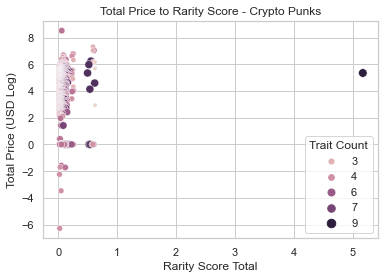

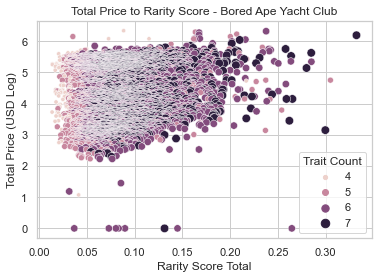

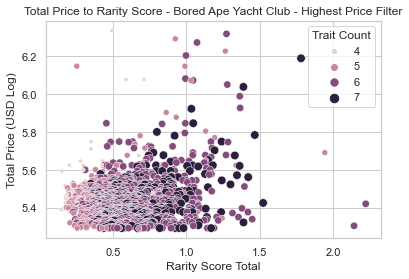

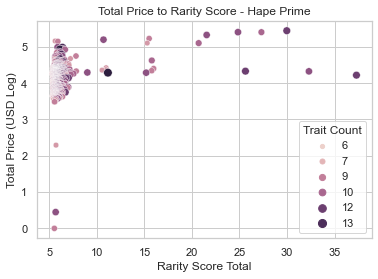

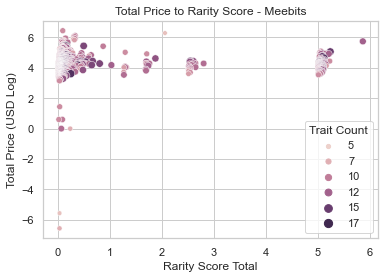

In [50]:
for idx, traits_sales_df in enumerate(traits_sales_dfs_list):
    ax = sns.scatterplot(data=traits_sales_df, x="rarity_total", y="total_price_usd_log", hue="trait_count", size="trait_count")
    ax.set(xlabel='Rarity Score Total', ylabel='Total Price (USD Log)', title='Total Price to Rarity Score - '+ zip_files_list[idx][0])
    plt.legend(title='Trait Count')
    plt.savefig('Plot_Total_Price_to_Rarity_Score_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()

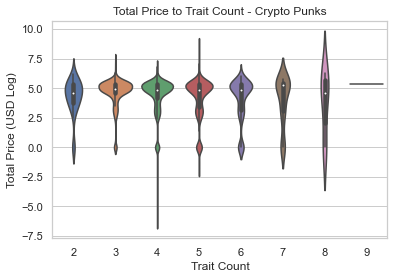

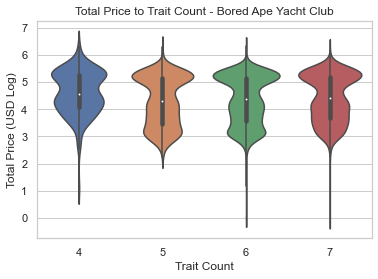

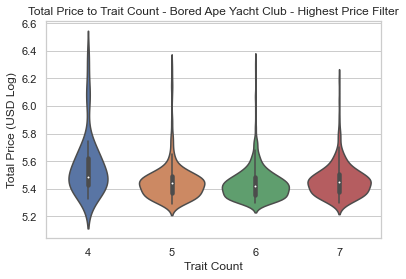

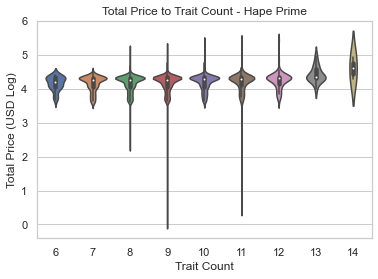

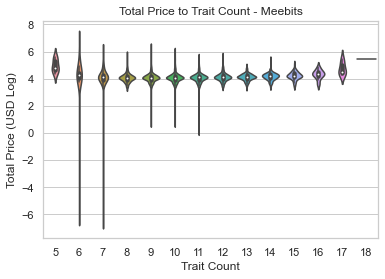

In [51]:
for idx, traits_sales_df in enumerate(traits_sales_dfs_list):
    ax = sns.violinplot(data=traits_sales_df, x="trait_count", y="total_price_usd_log")
    ax.set(xlabel='Trait Count', ylabel='Total Price (USD Log)', title='Total Price to Trait Count - ' + zip_files_list[idx][0])
    plt.savefig('Plot_Price_Count_violinplot_' +  zip_files_list[idx][0]  + '.svg')
    plt.show()


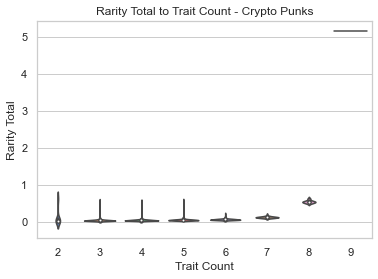

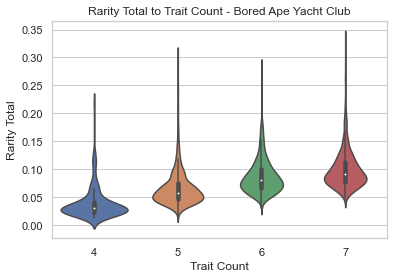

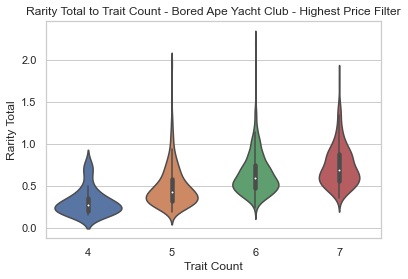

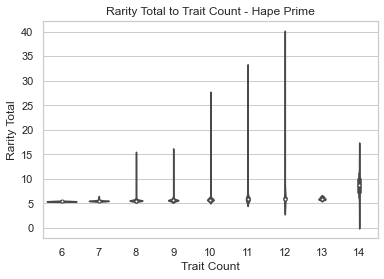

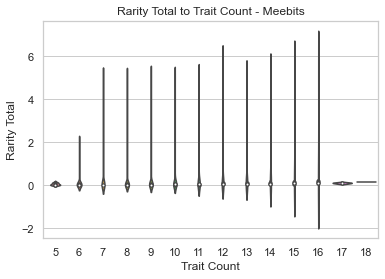

In [52]:
#violin plot the Trait Count vs the Rarity Total
for idx, traits_sales_df in enumerate(traits_sales_dfs_list):
    ax = sns.violinplot(data=traits_sales_df, x="trait_count", y="rarity_total")
    ax.set(xlabel='Trait Count', ylabel='Rarity Total', title='Rarity Total to Trait Count - ' + zip_files_list[idx][0])
    plt.savefig('Plot_RarityTotal_to_TraitCount_violinplot_' + zip_files_list[idx][0]  + '.svg')
    plt.show()


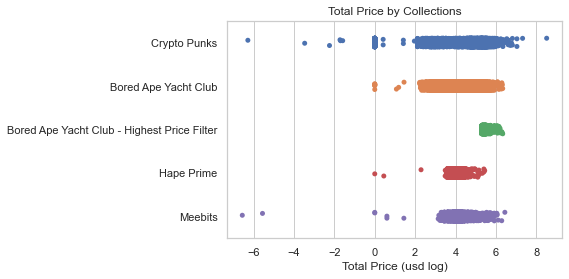

In [53]:
#stripplot the total price to Collection

#concat the collections
all_traits_sales_df = pd.concat(traits_sales_dfs_list)
all_traits_sales_df = all_traits_sales_df.astype({"token_id": int, "trait_count": int})

ax = sns.stripplot(data=all_traits_sales_df, x="total_price_usd_log", y="collection_name", jitter=0.1)
ax.set(xlabel='Total Price (usd log)', ylabel='', title='Total Price by Collections')
plt.savefig('Plot_Total_Price_by_Collections'  + '.svg')
plt.show()

In [54]:
print(all_traits_sales_df.head(5))

      token_id  trait_count    id   total_price  quantity  \
6600      9998            5  9998  1.244571e+23         1   
3630      5822            3  5822  8.000000e+21         1   
5021      7804            5  7804  4.200000e+21         1   
1705      3100            3  3100  4.200000e+21         1   
3456      5577            3  5577  2.501000e+21         1   

          event_timestamp  decimals  eth_price  usd_price  total_price_usd  \
6600  2021-10-28T23:50:37        18        1.0    2607.28     3.244944e+08   
3630  2022-02-12T20:30:36        18        1.0    2607.28     2.085824e+07   
5021  2021-03-11T00:48:39        18        1.0    2607.28     1.095058e+07   
1705  2021-03-11T20:57:01        18        1.0    2607.28     1.095058e+07   
3456  2022-02-09T03:31:23        18        1.0    2607.28     6.520807e+06   

      total_price_usd_log collection_name  rarity_total  
6600             8.511207    Crypto Punks      0.061394  
3630             7.319278    Crypto Punks      0

In [55]:
output_df = all_traits_sales_df.groupby('collection_name', as_index=False).agg({"total_price_usd_log": [np.mean, np.median], "rarity_total": [np.mean, np.median], "token_id": "count"})

#print(output_df.head())
output_df.columns = ['collection_name', 'mean_total_price_usd_log', 'median_total_price_usd_log', 'rarity_total_mean', 'rarity_total_median',  'collection_count']

output_df.to_json('collections_summary.json')
output_df.to_json()



'{"collection_name":{"0":"Bored Ape Yacht Club","1":"Bored Ape Yacht Club - Highest Price Filter","2":"Crypto Punks","3":"Hape Prime","4":"Meebits"},"mean_total_price_usd_log":{"0":4.3450151871,"1":5.4491644422,"2":4.3566607266,"3":4.1730838911,"4":4.0897958201},"median_total_price_usd_log":{"0":4.3732513561,"1":5.4313915581,"2":4.8630353834,"3":4.2698867669,"4":4.0892539487},"rarity_total_mean":{"0":0.0833858916,"1":0.6091370558,"2":0.0499319956,"3":5.7277553602,"4":0.2392998334},"rarity_total_median":{"0":0.0774933013,"1":0.5610980315,"2":0.0424809762,"3":5.6261046687,"4":0.0445007545},"collection_count":{"0":8502,"1":1379,"2":6601,"3":5139,"4":8072}}'